In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install pgmpy

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import common

In [5]:
date_set_path = "../temp_sets_100/"

# admissions

## Data Process

### Read samples

In [6]:
admissions_df = common.read_csv_no_rowid(date_set_path+"admissions.csv")

In [7]:
dob_df = pd.read_csv(date_set_path+"date_dob.csv")

In [8]:
# patients_df = pd.read_csv(date_set_path+"patients.csv")
# dob_df = patients_df.loc[:, ['subject_id', 'dob']]

### Data preproces

In [9]:
# Drop useless colums
admissions_df.drop(['diagnosis', 'hospital_expire_flag'], axis=1, inplace=True)

In [10]:
admissions_df = pd.merge(dob_df, admissions_df, how='inner', on='subject_id')

In [11]:
admissions_df.head()

,subject_id,dob,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,has_chartevents_data
0,569,1925-11-04,116412,2/21/2105 12:00,2/24/2105 17:17,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,NaN,NaN,1
1,26282,1930-03-20,123094,3/30/2152 23:32,4/7/2152 15:25,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,RUSS,UNOBTAINABLE,WIDOWED,WHITE,3/30/2152 18:44,3/31/2152 1:00,1
2,1762,2004-03-18,126479,3/19/2120 9:53,3/27/2120 14:45,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,1
3,14481,1918-05-06,129421,5/8/2116 7:30,5/13/2116 13:51,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,UNOBTAINABLE,WIDOWED,WHITE,NaN,NaN,1
4,21470,2001-05-19,107803,5/20/2195 9:25,5/22/2195 12:02,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,1


#### Deal with null values

In [12]:
# Check null value in table
common.nan_count(admissions_df)

Total columns: 17
Total rows: 123
--------------
subject_id                0
dob                       0
hadm_id                   0
admittime                 0
dischtime                 0
deathtime               112
admission_type            0
admission_location        0
discharge_location        0
insurance                 0
language                 52
religion                  1
marital_status           18
ethnicity                 0
edregtime                66
edouttime                66
has_chartevents_data      0
dtype: int64


In [13]:
# Set a value replacing the null time value
# nan_datetime=pd.to_datetime(0)

In [14]:
# admissions_df['dob'].fillna(value=nan_datetime, inplace=True)
# admissions_df['dod_hosp'].fillna(value=nan_datetime, inplace=True)
# admissions_df['dod_ssn'].fillna(value=nan_datetime, inplace=True)

In [15]:
common.nan_count(admissions_df)

Total columns: 17
Total rows: 123
--------------
subject_id                0
dob                       0
hadm_id                   0
admittime                 0
dischtime                 0
deathtime               112
admission_type            0
admission_location        0
discharge_location        0
insurance                 0
language                 52
religion                  1
marital_status           18
ethnicity                 0
edregtime                66
edouttime                66
has_chartevents_data      0
dtype: int64


#### Set the column types

In [16]:
admissions_df.dtypes

subject_id               int64
dob                     object
hadm_id                  int64
admittime               object
dischtime               object
deathtime               object
admission_type          object
admission_location      object
discharge_location      object
insurance               object
language                object
religion                object
marital_status          object
ethnicity               object
edregtime               object
edouttime               object
has_chartevents_data     int64
dtype: object

In [17]:
# Transfer some date type
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
admissions_df['deathtime'] = pd.to_datetime(admissions_df['deathtime'])
admissions_df['edregtime'] = pd.to_datetime(admissions_df['edregtime'])
admissions_df['edouttime'] = pd.to_datetime(admissions_df['edouttime'])

admissions_df['dob'] = pd.to_datetime(admissions_df['dob'])

In [18]:
admissions_df.dtypes

subject_id                       int64
dob                     datetime64[ns]
hadm_id                          int64
admittime               datetime64[ns]
dischtime               datetime64[ns]
deathtime               datetime64[ns]
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
religion                        object
marital_status                  object
ethnicity                       object
edregtime               datetime64[ns]
edouttime               datetime64[ns]
has_chartevents_data             int64
dtype: object

#### Deal with some special value

`dischtime` should be equals to `deathtime` (if `deathtime` is exist), so we drop the row where `dischtime` != `deathtime`

In [19]:
# admissions_df.loc[113]

In [20]:
admissions_df = admissions_df.drop(admissions_df.loc[(pd.isna(admissions_df['deathtime']) == False) & (admissions_df['dischtime'] != admissions_df['deathtime'])].index)

#### Process time data

For `deathtime`, If `deathtime` exist, it should euqal to `dischtime`, so I set `deathtime` = 1 if it exist. In sythetic data, set `deathtime` = `dischtime` if it is 1.

For others time data, I save the time difference as the columns. In sythetic data, I just need to use the time difference to calculate the exact time.

In [21]:
admissions_df['deathtime'] = admissions_df['deathtime'].apply(lambda flag: 1 if pd.isna(flag) == False else np.NaN)

In [22]:
def time_process(df, early_col_name, late_col_name):
    '''
    If 2 columns both exist, then use late_col - early_col, and save the difference as late_col
    '''

    if (pd.isna(df[early_col_name]) == False) & (pd.isna(df[late_col_name]) == False):
        return abs(np.int64(df[late_col_name].to_numpy()) - np.int64(df[early_col_name].to_numpy()))
    else:
        return np.NaN

In [23]:
admissions_df['dischtime'] = admissions_df.apply(time_process, args=('admittime', 'dischtime'), axis=1)
admissions_df['edouttime'] = admissions_df.apply(time_process, args=('admittime', 'edouttime'), axis=1)
admissions_df['admittime'] = admissions_df.apply(time_process, args=('dob', 'admittime'), axis=1)
admissions_df['edregtime'] = admissions_df.apply(time_process, args=('dob', 'edregtime'), axis=1)

In [24]:
admissions_df.drop(['dob'], axis=1, inplace=True)

In [25]:
admissions_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,has_chartevents_data
0,569,116412,5658206400000000000,278220000000000,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,NaN,NaN,1
1,26282,123094,7006692720000000000,661980000000000,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,RUSS,UNOBTAINABLE,WIDOWED,WHITE,7.006675e+18,5.280000e+12,1
2,1762,126479,3660717180000000000,708720000000000,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,1
3,14481,129421,6248561400000000000,454860000000000,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,UNOBTAINABLE,WIDOWED,WHITE,NaN,NaN,1
4,21470,107803,6122165100000000000,182220000000000,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,1


---

##  Build model

In [26]:
from sdv.tabular import CTGAN
from sdv.tabular import GaussianCopula
from sdv.constraints import FixedCombinations
from sdv.constraints import create_custom_constraint

In [27]:
admissions_df.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'has_chartevents_data'],
      dtype='object')

### Set constraint

In [28]:
# def time_is_valid(column_names, data):
#     admit_disch = (data['admittime'] <= data['dischtime'])

#     edreg_admit = \
#         (pd.isna(data['edregtime']) & pd.isna(data['edouttime'])) | \
#         ( \
#             ((pd.isna(data['edregtime']) == False) & (pd.isna(data['edouttime']) == False)) & \
#             ((data['admittime'] - data['edregtime']).apply(lambda x: 0 <= x.days  <= 1)) \
#         )

#     # admit_edout = (pd.isna(admissions_df['edregtime'])) | (admissions_df['admittime'] <= admissions_df['edouttime'])

#     edout_disch = \
#         (pd.isna(data['edregtime']) & pd.isna(data['edouttime'])) | \
#         ( \
#             ((pd.isna(data['edregtime']) == False) & (pd.isna(data['edouttime']) == False)) & \
#             ((data['dischtime'] - data['edouttime']).apply(lambda x: 0 <= x.days  <= 365)) \
#         )

#     # disch_death = (pd.isna(data['deathtime'])) | ((pd.isna(data['deathtime']) == False) & (data['dischtime'] == data['deathtime']))        
    
#     return admit_disch & edreg_admit & edout_disch

In [29]:
# def time_trasform(column_names, data):
#     # print(data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])
#     return data

# def time_reverse_transform(column_names, transformed_data):

#     is_death = (pd.isna(transformed_data['deathtime']) == False)
#     transformed_data.loc[is_death, ['deathtime']] = transformed_data[is_death]['dischtime'].values
#     transformed_data['deathtime'] = pd.to_datetime(transformed_data['deathtime'])

#     return transformed_data

In [30]:
# TimeProcess = create_custom_constraint(
#     is_valid_fn=time_is_valid,
#     transform_fn=time_trasform,
#     reverse_transform_fn=time_reverse_transform
# )

In [31]:
# time_constraint = TimeProcess(
#     column_names=['admittime', 'dischtime','edregtime', 'edouttime', 'deathtime']
# )

In [32]:
from sdv.constraints import Positive

In [33]:
admittime_positive = Positive(column_name='admittime')
dischtime_positive = Positive(column_name='dischtime')
edregtime_positive = Positive(column_name='edregtime')
edouttime_positive = Positive(column_name='edouttime')

In [34]:
constraints = [admittime_positive, dischtime_positive, edregtime_positive, edouttime_positive]

### Build model

In [35]:
train_data = admissions_df

In [36]:
best_model = common.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 122/122 [00:00<00:00, 2169.61it/s]

Gaussian Copula



Sampling rows: 100%|██████████| 122/122 [00:00<00:00, 4207.55it/s]


CTGAN


Sampling rows: 100%|██████████| 122/122 [00:00<00:00, 741.84it/s] 


CopulaGAN


Sampling rows: 100%|██████████| 122/122 [00:00<00:00, 888.51it/s]


TVAE


Sampling rows: 100%|██████████| 122/122 [00:00<00:00, 1172.36it/s]


Train finished!
Strat evaluating ...
All done!


In [38]:
model_save_path = date_set_path + "100_models/" + "admissions_model.pkl"
common.save_model(best_model, model_save_path)

In [384]:
# sample = model.sample(1000)

Sampling rows: 100%|██████████| 1000/1000 [00:00<00:00, 5124.28it/s]


In [385]:
# Add some original columns
# sample['hospital_expire_flag'] = sample['deathtime'].apply(lambda x: 0 if pd.isna(x) else 1)

---

## Evaluate data

In [57]:
from sdv.evaluation import evaluate

score_dict = {}

tabular_score = evaluate(tabular_sample, train_data)
gaussian_score = evaluate(gaussian_sample, train_data)
ctgan_score = evaluate(ctgan_sample, train_data)
copulagan_score = evaluate(copulagan_sample, train_data)
tvae_score = evaluate(tvae_sample, train_data)


score_dict['tabular_score'] = (tabular_model, tabular_score)
score_dict['gaussian_score'] = (gaussian_model, gaussian_score)
score_dict['ctgan_score'] = (ctgan_model, ctgan_score)
score_dict['copulagan_score'] = (copulagan_model, copulagan_score)
score_dict['tvae_score'] = (tvae_model, tvae_score)

In [58]:
best_model = sorted(score_dict.items(), key=lambda item: item[1][1]).pop()[1][0]

In [ ]:
best_model = common.build_model(constraints, train_data)

In [63]:
import cloudpickle

with open(date_set_path + "100_models/" + "admissions_model.pkl", 'wb') as f:
    cloudpickle.dump(best_model, f)

In [399]:
train_data.columns

Index(['subject_id', 'dob', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'has_chartevents_data'],
      dtype='object')

In [400]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.4356372626851349

In [401]:
evaluate(copula_sample, train_data, metrics=['DiscreteKLDivergence'])

0.4251797093493403

In [402]:
evaluate(tvae_sample, train_data, metrics=['DiscreteKLDivergence'])

0.6272251503354446

In [403]:
evaluate(gaussian_sample, train_data, metrics=['DiscreteKLDivergence'])

0.4245593922908813

In [404]:
evaluate(tabular_sample, train_data, metrics=['DiscreteKLDivergence'])

0.2923930537806543

In [405]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.4343821695319198

In [406]:
evaluate(copula_sample, train_data, metrics=['ContinuousKLDivergence'])

0.4786872168728297

In [407]:
evaluate(tvae_sample, train_data, metrics=['ContinuousKLDivergence'])

0.6379412948258995

In [408]:
evaluate(gaussian_sample, train_data, metrics=['ContinuousKLDivergence'])

0.4057998595751357

In [409]:
evaluate(tabular_sample, train_data, metrics=['ContinuousKLDivergence'])

0.49789472858754336

In [415]:
tvae_sample['admission_type'].value_counts()

EMERGENCY    116
ELECTIVE       6
Name: admission_type, dtype: int64

<AxesSubplot:>

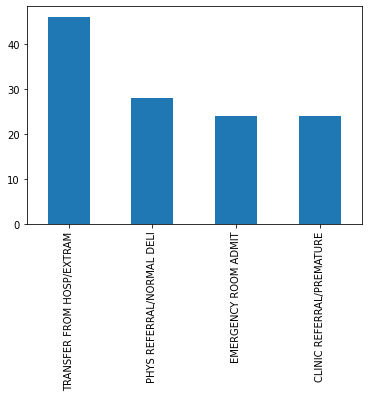

In [416]:
tvae_sample['admission_location'].value_counts().plot.bar()

In [417]:
train_data['admission_type'].value_counts()

EMERGENCY    89
ELECTIVE     17
NEWBORN      13
URGENT        3
Name: admission_type, dtype: int64

<AxesSubplot:>

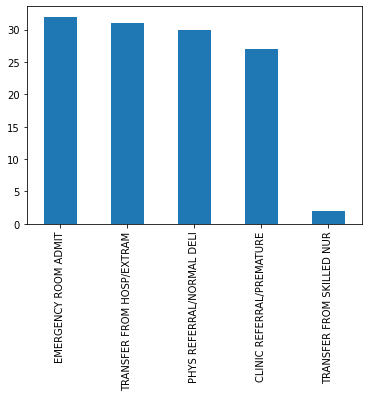

In [418]:
train_data['admission_location'].value_counts().plot.bar()

<AxesSubplot:xlabel='admission_type', ylabel='admission_location'>

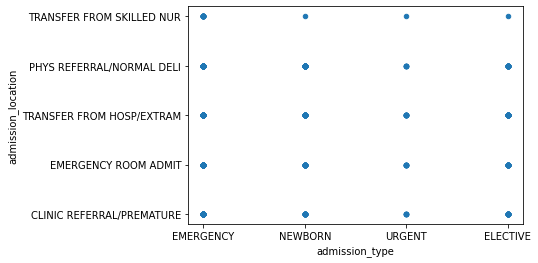

In [419]:
sample.plot.scatter(x='admission_type',y='admission_location')

<AxesSubplot:xlabel='admission_type', ylabel='admission_location'>

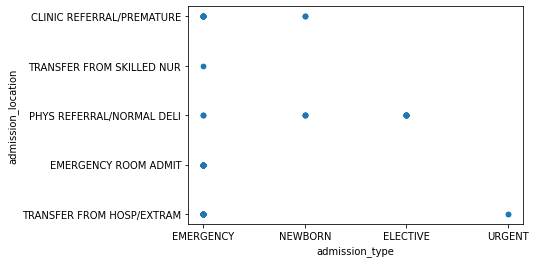

In [420]:
train_data.plot.scatter(x='admission_type',y='admission_location')

<AxesSubplot:>

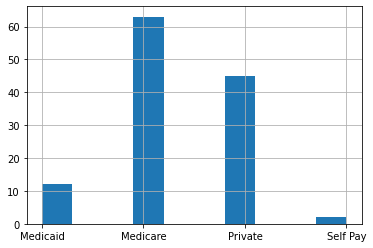

In [421]:
train_data.sort_values(by='insurance')['insurance'].hist()

<AxesSubplot:>

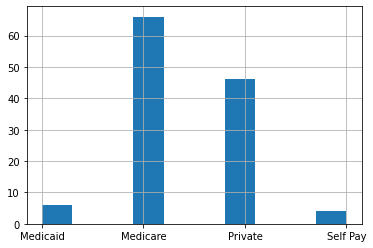

In [422]:
copula_sample.sort_values(by='insurance')['insurance'].hist()

In [423]:
len(train_data)

122